# Experiments

## Simulated LFs

Generating a toy dataset and simulated values of LFs. Here we also set the prior probability on the labels:

In [1]:
import torch
import random
import numpy as np
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [2]:
m = 10000
LABEL_PROBS = {-1: 0.40, 1: 0.60}
y_true = np.random.choice([-1, 1], size=m, p=[LABEL_PROBS[-1], LABEL_PROBS[1]])

s = 2 * torch.pi * torch.rand(m, 1)
r = 0.5 * (torch.tensor(y_true).view(-1, 1) + 1)    # -1 -> r = 0, +1 -> r = 1
x = torch.cat([r * torch.cos(s), r * torch.sin(s)], dim=1) + 0.05 * torch.randn(m, 2)

t = np.linspace(0, 2*np.pi, 100)
x0 = 0.5 * np.cos(t)
x1 = 0.5 * np.sin(t)
x_neg = x[torch.where(torch.tensor(y_true) == -1)]
x_pos = x[torch.where(torch.tensor(y_true) == +1)]

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

def plot_dataset(x_neg, x_pos):
    m = len(x_neg)
    limit = m // 10
    plt.scatter(x_neg[:limit, 0], x_neg[:limit, 1], s=2.0, color="C0", label="y = -1")
    plt.scatter(x_pos[:limit, 0], x_pos[:limit, 1], s=2.0, color="C1", label="y = 1")
    plt.plot(x0, x1, color='black', linewidth=1, linestyle='dashed', label="r = 0.5")
    plt.xlabel("x$_0$")
    plt.ylabel("x$_1$")
    plt.legend()
    plt.axis('equal');

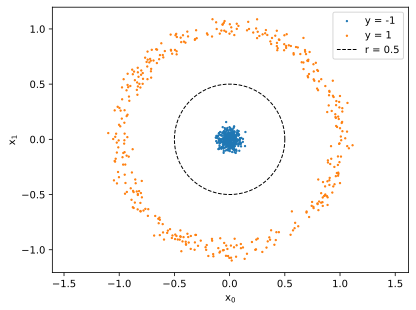

In [4]:
plot_dataset(x_neg, x_pos)

Note that radius less than 0.5 determines the label as negative (with high probability):

In [5]:
# 2x - 1: [0, 1] -> [-1, 1] 
((2 * (torch.sqrt((x ** 2).sum(dim=1)) >= 0.5).float() - 1).numpy() == y_true).mean()

1.0

We use this to write simulated LFs with given parameters:

In [6]:
def lf_sim(coverage, accuracy):
    def predict(x):
        m = x.shape[0]
        cov_mask = torch.rand(m) < coverage
        acc_mask = torch.tensor(np.random.choice([-1, 1], size=sum(cov_mask).item(), p=[1 - accuracy, accuracy]))
        y = 2 * (torch.sqrt((x ** 2).sum(dim=1)) >= 0.5).long() - 1
        y[cov_mask == 0] = 0
        y[cov_mask == 1] *= acc_mask
        return y
    return predict

# example
p = lf_sim(0.3, 0.8)(x).numpy()
print("cov: ", (p != 0).mean())
print("acc: ", (p[p != 0] == y_true[p != 0]).mean())
print("acc+:", (p[(p != 0) & (y_true == +1)] == y_true[(p != 0) & (y_true == +1)]).mean())
print("acc-:", (p[(p != 0) & (y_true == -1)] == y_true[(p != 0) & (y_true == -1)]).mean())

cov:  0.2993
acc:  0.7958569996658871
acc+: 0.7883418222976797
acc-: 0.8066884176182708


Initializing the empirical LF matrix. Some have fairly low accuracy:

In [7]:
import pandas as pd
lf_params = [(0.30, 0.75), (0.50, 0.65), (0.40, 0.70), (0.20, 0.80), (0.25, 0.90)]
labeling_funcs = [lf_sim(*param) for param in lf_params]

df = pd.DataFrame({"y": y_true})
df["x0"] = x[:, 0].numpy()
df["x1"] = x[:, 1].numpy()
for j, lf in enumerate(labeling_funcs):
    df[f"LF{j + 1}"] = lf(x).int().numpy()

print(df.shape)
df.head()

(10000, 8)


,y,x0,x1,LF1,LF2,LF3,LF4,LF5
0,1,-1.099107,0.056581,0,0,-1,0,0
1,1,0.102344,-0.986159,1,0,1,0,1
2,1,0.792552,0.459719,0,0,0,0,1
3,1,0.682795,0.809001,0,0,-1,0,1
4,1,-0.315244,0.901337,0,-1,-1,-1,1


Splitting for evaluation:

In [8]:
# 80-20
SPLIT_RATIO = 0.80
m = x.shape[0]
x_train = x[:int(SPLIT_RATIO * m)]
x_valid = x[int(SPLIT_RATIO * m):]
y_train = torch.tensor(y_true[:int(SPLIT_RATIO * m)])
y_valid = torch.tensor(y_true[int(SPLIT_RATIO * m):])

## Generative model training

In [9]:
from tqdm.notebook import tqdm


class GenModel:
    def __init__(self, labeling_funcs: list, label_probs: dict):
        self.lfs = labeling_funcs
        self.py = torch.tensor([0.0, label_probs[1], label_probs[-1]])  # zero-index = dummy
        self.params = None

    def loss_fn(self, L):
        p_pos = self.infer_joint_proba(L, +1)
        p_neg = self.infer_joint_proba(L, -1)
        p = p_pos + p_neg   # Note: p has shape [m,]
        return -torch.log(p).mean()

    def fit(self, x_train, x_valid=None, bs=32, epochs=1, lr=0.0001, lr_decay=1.0):
        """MLE estimate of coverage and accuracy parameters of LFs."""
        L_train = self.lf_outputs(x_train)
        L_valid = self.lf_outputs(x_valid) if x_valid is not None else None
        m, n = L_train.shape

        delta = torch.randn(n, requires_grad=True)  # coverage score
        gamma = torch.randn(n, requires_grad=True)  # accuracy score
        delta.retain_grad()
        gamma.retain_grad()

        history = {"train": [], "valid": [], "valid_steps": []}
        checkpoint = (None, np.inf)

        try:
            for e in tqdm(range(epochs)):
                B = torch.randperm(m)
                for i in range(m // bs):
                    batch = B[i * bs: (i + 1) * bs]

                    # Note: weights are scores => need to convert to probs (p = σ(w))
                    p_delta = 1. / (1. + torch.exp(-delta))
                    p_gamma = 1. / (1. + torch.exp(-gamma))
                    self.params = torch.stack([
                        1 - p_delta,                # abstained
                        p_delta * p_gamma,          # accurate
                        p_delta * (1 - p_gamma)     # inaccurate
                    ], dim=0)

                    loss = self.loss_fn(L_train[batch])
                    loss.backward(retain_graph=True)

                    with torch.no_grad():
                        delta -= lr * (lr_decay ** (e / epochs)) * delta.grad
                        gamma -= lr * (lr_decay ** (e / epochs)) * gamma.grad
                        delta.grad = None
                        gamma.grad = None

                    history["train"].append(loss.item())
                
                with torch.no_grad():
                    if L_valid is not None:
                        val_loss = self.loss_fn(L_valid)
                        history["valid"].append(val_loss.item())
                        history["valid_steps"].append((e + 1) * (m // bs))
                        if val_loss.item() < checkpoint[1]:
                            checkpoint = (self.params, val_loss.item())

        except KeyboardInterrupt:
            print("Training stopped.")

        finally:
            # Note: model is agnostic to relabeling. Row swap when model confuses +1 and -1.
            self.params = checkpoint[0]
            if (self.params[1, :] / (1 - self.params[0, :])).mean() < 0.5:
                row_swap = torch.tensor([[1, 0, 0], [0, 0, 1], [0, 1, 0]]).float()
                self.params = row_swap @ self.params
            
            return history
    
    def predict(self, x, t=0.5):
        """Label inference using p(y | Λ_i)."""
        L = self.lf_outputs(x)
        p = self.target_cond_proba(+1, L) >= t
        return 2 * p.long() - 1
    
    def target_cond_proba(self, y, L):
        """Estimate of target prob given LF observations, i.e. p(y | Λ)."""
        p_neg = self.infer_joint_proba(L, -1)            # p(Λ_i, y=-1)
        p_pos = self.infer_joint_proba(L, +1)            # p(Λ_i, y=+1)
        p_tot = p_neg + p_pos                            # p(Λ_i) for i = 1, ..., m
        return self.infer_joint_proba(L, y) / p_tot      # p(y | Λ_i) = p(Λ_i, y) / p(Λ_i)
    
    def infer_joint_proba(self, L, y: int):
        """Return the estimated joint proba p(Λ_i, y), i.e. the output has shape [m,]."""
        n = L.shape[1]
        return self.py[y] * self.params[y * L, torch.arange(n)].prod(dim=1)     # p(Λ_i, y) = p(Λ_i | y) p(y)
    
    def lf_outputs(self, x):
        """Construct Λ matrix from LFs."""
        L = torch.stack([lf(x) for lf in self.lfs], dim=1)
        return L.long()


gen_model = GenModel(labeling_funcs, LABEL_PROBS)
history = gen_model.fit(x_train, x_valid, bs=4096, epochs=20000, lr=0.06, lr_decay=0.8)

  0%|          | 0/20000 [00:00<?, ?it/s]

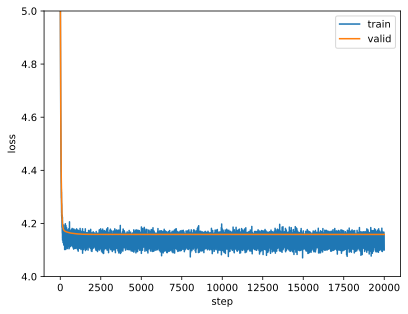

In [10]:
plt.plot(history["train"], label="train")
plt.plot(history["valid_steps"], history["valid"], label="valid")
plt.ylabel("loss")
plt.xlabel("step")
plt.ylim(4, 5)
plt.legend();

In [11]:
print("latent:")
print([f"{cov:.4f}" for cov, acc in lf_params])
print([f"{acc:.4f}" for cov, acc in lf_params])

latent:
['0.3000', '0.5000', '0.4000', '0.2000', '0.2500']
['0.7500', '0.6500', '0.7000', '0.8000', '0.9000']


Model is able to learn the latent probabilities:

In [12]:
print("estimate:")
print([f"{cov:.4f}" for cov in (1 - gen_model.params[0, :]).tolist()])
print([f"{acc:.4f}" for acc in (gen_model.params[1, :] / (1 - gen_model.params[0, :])).tolist()])

estimate:
['0.2969', '0.4998', '0.3952', '0.2024', '0.2445']
['0.7304', '0.6499', '0.7139', '0.8279', '0.8729']


The trained model can be used to estimate joint probabilities of LF outputs and targets:

In [13]:
l = torch.tensor([[-1, -1, -1, -1, -1]])
print(gen_model.infer_joint_proba(l, +1).item())
print(gen_model.infer_joint_proba(l, -1).item())

1.0288449630024843e-06
0.00028423345065675676


The conditional probabilities of targets given LF outputs sum to 1:

In [14]:
# Simple test that the model learned (without using latent labels):
l = torch.tensor([[-1, -1, -1, -1, -1]])
print(gen_model.target_cond_proba(+1, l).item())
print(gen_model.target_cond_proba(-1, l).item())

0.003606662852689624
0.9963933229446411


### Label inference

Soft labels can be generated for a test input using $p_{\hat{\theta}}(y \mid \lambda(\boldsymbol{\mathsf{x}}))$ calculated using learned LF parameters. This already takes into account the prior label distribution. In particular, if $\lambda(\boldsymbol{\mathsf{x}}) = \boldsymbol{0}$, then the model falls back to the prior label distribution. Evaluating using latent labels:

In [15]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score


def evaluate(model, x, y, t=0.5, verbose=True):
    m = x.shape[0]
    preds = model.predict(x) if t is None else model.predict(x, t)
    f1 = f1_score(y.numpy(), preds.numpy(), average="weighted")
    recall = recall_score(y.numpy(), preds.numpy(), average="weighted")
    precision = precision_score(y.numpy(), preds.numpy(), average="weighted")
    
    if verbose:
        print(confusion_matrix(y.numpy(), preds.numpy()))
    
    return {
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "m": m, "message": f"m={m}, f1={f1:.5f}, t={t:.5f}"
    }

print(evaluate(gen_model, x_train, y_train)["message"]); print()
print(evaluate(gen_model, x_valid, y_valid)["message"])

[[2068 1175]
 [ 758 3999]]
m=8000, f1=0.75515, t=0.50000

[[ 490  296]
 [ 189 1025]]
m=2000, f1=0.75376, t=0.50000


## Noise-aware training

Noise-aware training amounts to weighting the loss with the estimate of the generative model for each target ${p_{\hat{\theta}}(y \mid \lambda(\boldsymbol{\mathsf{x}}))} = {p_{\hat{\theta}}(y, \lambda(\boldsymbol{\mathsf{x}}))}\, /\, {p_{\hat{\theta}}(\lambda(\boldsymbol{\mathsf{x}}))}.$ This allows us to train a model without labels:

In [16]:
import torch.nn as nn
from tempfile import NamedTemporaryFile
np.random.seed(42); torch.manual_seed(42)


class NoiseAwareTrainer:
    def __init__(self, clf, gen_model, labeling_funcs: list):
        self.clf = clf
        self.lfs = labeling_funcs
        self.gen_model = gen_model

    def loss_fn(self, L, x):
        with torch.no_grad():
            p_neg_cond = self.gen_model.target_cond_proba(-1, L)
            p_pos_cond = self.gen_model.target_cond_proba(+1, L)
            p = torch.concat([p_neg_cond, p_pos_cond], dim=0)
        
        fx = self.clf(x)
        s = torch.concat([-1 * fx, 1 * fx], dim=0)
        return (torch.log(1 + torch.exp(-s)) * p).mean()

    def run(self, x_train, x_valid=None, epochs=10, bs=8, lr=0.001, alpha=0.0, momentum=0.1):
        m = x_train.shape[0]
        history = {"train": [], "valid": [], "valid_steps": []}
        best_loss = np.inf
        best_epoch = 0
        optim = torch.optim.SGD(self.clf.parameters(), lr=lr, weight_decay=alpha, momentum=momentum)
        tmp = NamedTemporaryFile(suffix=".pt", delete=True)
        L_train = self.lf_outputs(x_train)
        L_valid = self.lf_outputs(x_valid) if x_valid is not None else None

        try: 
            for epoch in tqdm(range(epochs)):
                B = torch.randperm(m)
                for i in range(m // bs):
                    batch = B[i * bs: (i + 1) * bs]
                    loss = self.loss_fn(L_train[batch], x_train[batch])

                    # gradient step
                    loss.backward()
                    optim.step()
                    optim.zero_grad()

                    # callbacks
                    history["train"].append(loss.item())
                            
                    del loss
                    torch.cuda.empty_cache()
                
                with torch.no_grad():
                    if x_valid is not None:
                        val_loss = loss = self.loss_fn(L_valid, x_valid)
                        history["valid"].append(val_loss.item())
                        history["valid_steps"].append((epoch + 1) * (m // bs))
                        if val_loss < best_loss:
                            best_loss = val_loss.item()
                            best_epoch = epoch
                            torch.save(self.clf.state_dict(), tmp.name)

                if epoch - best_epoch > int(0.05 * epochs):
                    print(f"Early stopping at epoch {epoch}...")
                    raise KeyboardInterrupt

        except KeyboardInterrupt:
            print("Training stopped.")

        finally:
            print(f"Best valid loss: {best_loss}")
            self.clf.load_state_dict(torch.load(tmp.name))
            return history
    
    def lf_outputs(self, x):
        L = torch.stack([lf(x) for lf in self.lfs], dim=1).long()
        return L

    @torch.no_grad()
    def predict_proba(self, x):
        s = self.clf(x).view(-1)
        return 1 / (1 + torch.exp(-s))

    @torch.no_grad()
    def predict(self, x, t=0.5):
        s = self.predict_proba(x)
        return 2 * (s > t).long() - 1


clf = nn.Sequential(nn.Linear(2, 8), nn.SELU(), nn.Linear(8, 1))
trainer = NoiseAwareTrainer(clf, gen_model, labeling_funcs=labeling_funcs)
history = trainer.run(x_train, x_valid, epochs=120, bs=32, lr=0.003, alpha=0.0, momentum=0.1)

  0%|          | 0/120 [00:00<?, ?it/s]

Best valid loss: 0.34659114480018616


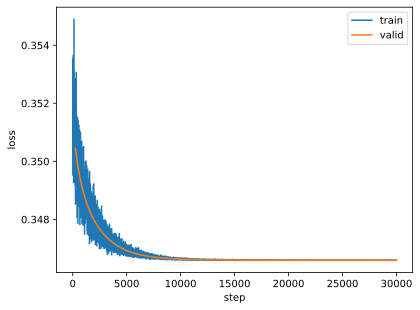

In [17]:
plt.plot(history["train"], label="train")
plt.plot(history["valid_steps"], history["valid"], label="valid")
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

In [18]:
print(evaluate(trainer, x_train, y_train, t=0.5)["message"]); print()
print(evaluate(trainer, x_valid, y_valid, t=0.5)["message"])

[[3243    0]
 [ 929 3828]]
m=8000, f1=0.88487, t=0.50000

[[786   0]
 [257 957]]
m=2000, f1=0.87292, t=0.50000


The threshold for predicting hard labels can be calibrated by using the prior label distribution. This significantly improves F1. Here we use the entirety of our data (i.e. `x`):

In [19]:
from collections import Counter

calibration_score = [] # lower = better
thresholds = np.linspace(-1, 1, num=500)
for t in thresholds:
    c = Counter(trainer.predict(x, t).tolist())
    n = len(x)
    c[-1] = c[-1] / n 
    c[+1] = c[+1] / n 
    calibration_score.append(-LABEL_PROBS[-1] * np.log(c[-1]) + -LABEL_PROBS[+1] * np.log(c[+1]))


t_best = thresholds[np.argmin(calibration_score)]
print(evaluate(trainer, x_train, y_train, t=t_best)["message"]); print()
print(evaluate(trainer, x_valid, y_valid, t=t_best)["message"])

[[3243    0]
 [ 500 4257]]
m=8000, f1=0.93800, t=0.49900

[[ 786    0]
 [ 128 1086]]
m=2000, f1=0.93663, t=0.49900


<br>

If we have a small but varied labeled subset of the data, then we can use that to tune the threshold. The following iteratively finds the threshold that maximizes weighted F1 on the validation set:

[[3243    0]
 [ 363 4394]]
m=8000, f1=0.95493, t=0.49750

[[ 785    1]
 [  98 1116]]
m=2000, f1=0.95091, t=0.49750


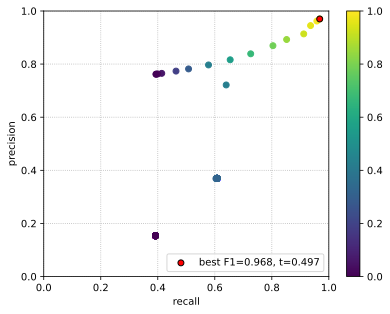

In [24]:
def pr_curve(model, x, y, num_thresholds, min_t=0.0, max_t=1.0):
    p, r, t, f = [], [], [], []
    for threshold in np.linspace(min_t, max_t, num_thresholds):
        preds = model.predict(x, threshold).numpy()
        f.append(f1_score(y.numpy(), preds, average="weighted"))
        r.append(recall_score(y.numpy(), preds, average="weighted"))
        p.append(precision_score(y.numpy(), preds, average="weighted"))
        t.append(threshold)
    
    return p, r, t, f

def plot_pr_curve(model, x, y, num_thresholds=200, min_t=0.0, max_t=1.0):
    """Tune threshold based on validation set."""
    p, r, t, f = pr_curve(model, x, y, num_thresholds, min_t, max_t);
    t_best_ = np.argmax(f)
    t_best = t[t_best_]

    # plotting the sample F1s
    plt.grid(linestyle="dotted", zorder=0)
    plt.scatter(r, p, c=f, zorder=2)
    plt.scatter(x=r[t_best_], y=p[t_best_], edgecolor="k", facecolor="red", label=f"best F1={f[t_best_]:.3f}, t={t_best:.3f}", zorder=3)
    plt.colorbar()
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc="lower right")

    return t_best


# Tuning the threshold on a labeled subset (here 500 pts)
t_best = plot_pr_curve(trainer, x_valid[:500], y_valid[:500], num_thresholds=1000, min_t=0.0, max_t=1.0)
print(evaluate(trainer, x_train, y_train, t=t_best)["message"]); print()
print(evaluate(trainer, x_valid, y_valid, t=t_best)["message"])

**Remark.** Model has learned fairly well despite having suboptimal LFs.